# TV-LIF2HH - step current

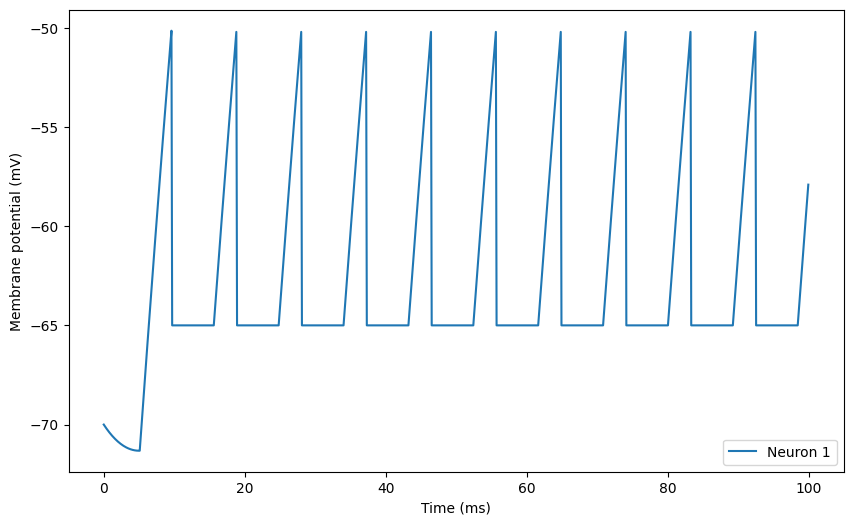

In [2]:
from brian2 import *
%matplotlib inline

start_scope()

# Global Parameters
simulation_time = 100 * ms
V_REST = -70 * mV
V_RESET = -65 * mV
FIRING_THRESHOLD = -50 * mV
MEMBRANE_RESISTANCE = 10. * Mohm
ABSOLUTE_REFRACTORY_PERIOD = 6.0 * ms
MEMBRANE_TIME_SCALE = 20.0 * ms



G_L = 10 * nsiemens      
E_L = -65 * mV           

G_NA = 35 * nsiemens     
E_NA = 55 * mV           

G_K = 9 * nsiemens       
E_K = -90 * mV          

t_start = 5
t_end = 100
unit_time = ms
amplitude = 30 * uA
append_zero = True   

gs = G_L + G_NA + G_K
# Create the input current for neurons
tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size, 1)) * amp
tmp[t_start: t_end + 1, 0] = (1 / (gs * MEMBRANE_RESISTANCE)) * amplitude
input_current = TimedArray(tmp, dt=1. * unit_time)



eqs_L = """
dv/dt = ((-(v - E_L) * G_L) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE  + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE : volt (unless refractory)
"""


eqs_Na = """
dv/dt = ((-(v - E_NA) * G_NA) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE : volt (unless refractory)
"""

eqs_K = """
dv/dt = ((-(v - E_K) * G_K) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE: volt (unless refractory)
"""

#Na, K, and L channels

neuronNa = NeuronGroup(1, model=eqs_Na, reset='v = 50 * mV', threshold='v > 65 * mV',
                       refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronNa.v = V_REST

neuronK = NeuronGroup(1, model=eqs_K, reset='v = -85 * mV', threshold='v > -70 * mV',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronK.v = V_REST

neuronL = NeuronGroup(1, model=eqs_L, reset='v = -65 * mV', threshold='v > -50 * mV',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronL.v = V_REST


state_monitorNa = StateMonitor(neuronNa, ["v"], record=True)
state_monitorK = StateMonitor(neuronK, ["v"], record=True)
state_monitorL = StateMonitor(neuronL, ["v"], record=True)


run(simulation_time)

start_scope()

input_current_neuron1 = ((state_monitorL.v[0] - V_REST) + (state_monitorK.v[0] - V_REST) + 
                         (state_monitorNa.v[0] - V_REST)) / MEMBRANE_RESISTANCE


input_current_neuron1 = TimedArray(input_current_neuron1, dt=defaultclock.dt)


eqs_neuron1 = """
dv/dt = ((-(v - E_K) * gs) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current_neuron1(t) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE: volt (unless refractory)
"""

neuron1 = NeuronGroup(1, model=eqs_neuron1, reset='v = V_RESET', threshold='v > FIRING_THRESHOLD',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuron1.v = V_REST

# StateMonitor for neuron 1
state_monitor1 = StateMonitor(neuron1, ["v"], record=True)
spikemon1 = SpikeMonitor(neuron1)

run(simulation_time)


figure(figsize=(10, 6))
# plot(state_monitorNa.t/ms, state_monitorNa.v[0]/mV, label='Sodium Channel (Na)')
# plot(state_monitorK.t/ms, state_monitorK.v[0]/mV, label='Potassium Channel (K)')
# plot(state_monitorL.t/ms, state_monitorL.v[0]/mV, label='Leak Channel (L)')
plot(state_monitor1.t/ms, state_monitor1.v[0]/mV, label='Neuron 1')
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()
show()

# Hodgkin Huxley - step current

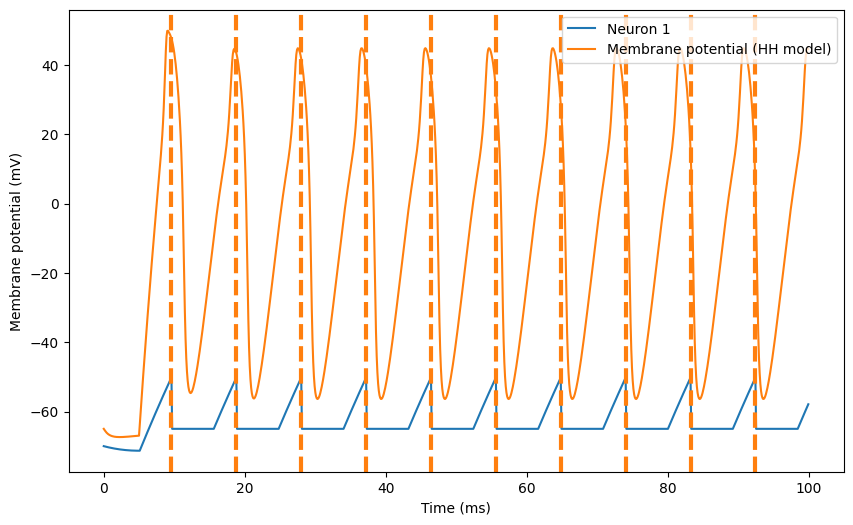

In [3]:

start_scope()


simulation_time = 100 * ms

El = -65 * mV             # Resting potential for Leak channel
EK = -77 * mV             # Resting potential for Potassium channel
ENa = 50 * mV             # Resting potential for Sodium channel
gl = 0.1 * msiemens       # Adjusted conductance for Leak channel
gK = 30 * msiemens        # Adjusted conductance for Potassium channel
gNa = 120 * msiemens      # Adjusted conductance for Sodium channel
C = 1 * ufarad            # Membrane capacitance


t_start = 5
t_end = 100
amplitude = 30 * uA

# Create the input current for the neuron
tmp_size = 1 + t_end
tmp = np.zeros((tmp_size, 1)) * amp
tmp[t_start: t_end + 1, 0] = amplitude
input_current = TimedArray(tmp, dt=1 * ms)

# Hodgkin-Huxley model equations 
eqs = """
I_e = input_current(t,i) : amp
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) : amp
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1
dvm/dt = membrane_Im/C : volt
"""

neuron = NeuronGroup(1, eqs, method="exponential_euler")

neuron.vm = El
neuron.m = 0.05
neuron.h = 0.6
neuron.n = 0.32

state_monitor = StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

run(simulation_time)


figure(figsize=(10, 6))
plot(state_monitor1.t/ms, state_monitor1.v[0]/mV, label='Neuron 1')
for t in spikemon1.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
plot(state_monitor.t/ms, state_monitor.vm[0]/mV, label="Membrane potential (HH model)")
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()
show()


# TV - LIF2HH - SINE WAVE

WARNING    't' is an internal variable of group 'neurongroup_10', but also exists in the run namespace with the value 92.4 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'neurongroup_8', but also exists in the run namespace with the value 92.4 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'neurongroup_9', but also exists in the run namespace with the value 92.4 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 92.4 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


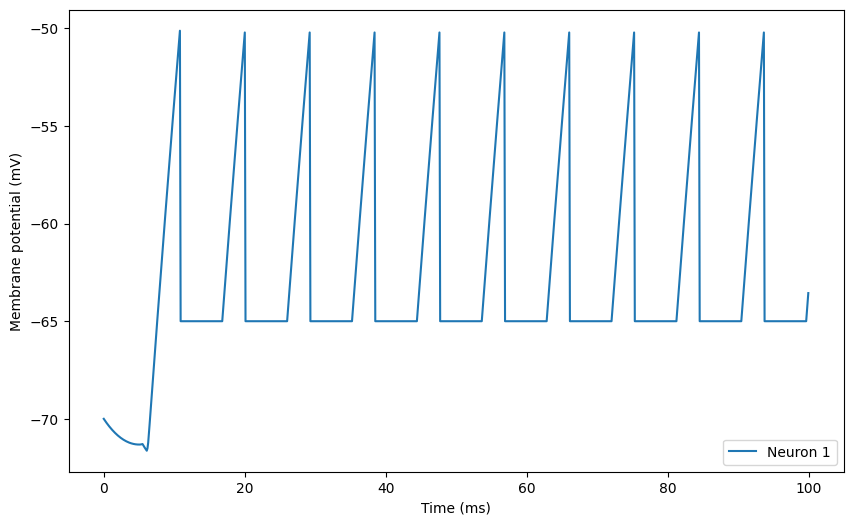

In [4]:
import math
import numpy
start_scope()

# Global Parameters
simulation_time = 100 * ms
V_REST = -70 * mV
V_RESET = -65 * mV
FIRING_THRESHOLD = -50 * mV
MEMBRANE_RESISTANCE = 10. * Mohm
ABSOLUTE_REFRACTORY_PERIOD = 6.0 * ms
MEMBRANE_TIME_SCALE = 20.0 * ms



G_L = 10 * nsiemens      
E_L = -65 * mV           

G_NA = 35 * nsiemens     
E_NA = 55 * mV           

G_K = 9 * nsiemens       
E_K = -90 * mV   

gs = G_L + G_NA + G_K

t_start = 5
t_end = 100
unit_time = ms
append_zero = True
frequency = 5 * Hz  # Frequency of the sine wave
amplitude = 20 * uA  # Amplitude of the sine wave
phase_offset = 0 
direct_current = 2. * namp

tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size, 1)) * amp
if t_end > t_start:  # if deltaT is zero, we return a zero current
    phi = range(0, (t_end - t_start) + 1)
    phi = phi * unit_time * frequency
    phi = phi * 2. * math.pi + phase_offset
    c = numpy.sin(phi)
    c = (direct_current + c * amplitude)
    tmp[t_start: t_end + 1, 0] = c
input_current = TimedArray(tmp, dt=1. * unit_time)


eqs_L = """
dv/dt = ((-(v - E_L) * G_L) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE  + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE : volt (unless refractory)
"""


eqs_Na = """
dv/dt = ((-(v - E_NA) * G_NA) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE : volt (unless refractory)
"""

eqs_K = """
dv/dt = ((-(v - E_K) * G_K) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE: volt (unless refractory)
"""

#Na, K, and L channels

neuronNa = NeuronGroup(1, model=eqs_Na, reset='v = 50 * mV', threshold='v > 65 * mV',
                       refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronNa.v = V_REST

neuronK = NeuronGroup(1, model=eqs_K, reset='v = -85 * mV', threshold='v > -70 * mV',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronK.v = V_REST

neuronL = NeuronGroup(1, model=eqs_L, reset='v = -65 * mV', threshold='v > -50 * mV',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronL.v = V_REST


state_monitorNa = StateMonitor(neuronNa, ["v"], record=True)
state_monitorK = StateMonitor(neuronK, ["v"], record=True)
state_monitorL = StateMonitor(neuronL, ["v"], record=True)


run(simulation_time)

start_scope()

input_current_neuron1 = ((state_monitorL.v[0] - V_REST) + (state_monitorK.v[0] - V_REST) + 
                         (state_monitorNa.v[0] - V_REST)) / MEMBRANE_RESISTANCE


input_current_neuron1 = TimedArray(input_current_neuron1, dt=defaultclock.dt)


eqs_neuron1 = """
dv/dt = ((-(v - E_K) * gs) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current_neuron1(t) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE: volt (unless refractory)
"""

neuron1 = NeuronGroup(1, model=eqs_neuron1, reset='v = V_RESET', threshold='v > FIRING_THRESHOLD',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuron1.v = V_REST

# StateMonitor for neuron 1
state_monitor1 = StateMonitor(neuron1, ["v"], record=True)
spikemon1 = SpikeMonitor(neuron1)

run(simulation_time)


figure(figsize=(10, 6))
# plot(state_monitorNa.t/ms, state_monitorNa.v[0]/mV, label='Sodium Channel (Na)')
# plot(state_monitorK.t/ms, state_monitorK.v[0]/mV, label='Potassium Channel (K)')
# plot(state_monitorL.t/ms, state_monitorL.v[0]/mV, label='Leak Channel (L)')
plot(state_monitor1.t/ms, state_monitor1.v[0]/mV, label='Neuron 1')
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()
show()

# HODGKIN HUXLEY - SINE WAVE

WARNING    't' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 92.4 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


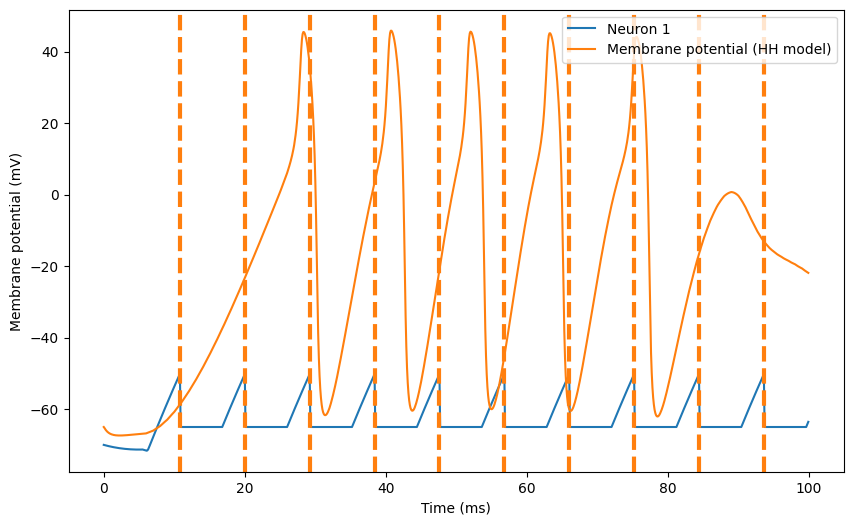

In [5]:

start_scope()


simulation_time = 100 * ms

El = -65 * mV             # Resting potential for Leak channel
EK = -77 * mV             # Resting potential for Potassium channel
ENa = 50 * mV             # Resting potential for Sodium channel
gl = 0.1 * msiemens       # Adjusted conductance for Leak channel
gK = 30 * msiemens        # Adjusted conductance for Potassium channel
gNa = 120 * msiemens      # Adjusted conductance for Sodium channel
C = 1 * ufarad            # Membrane capacitance

gs = G_L + G_NA + G_K

t_start = 5
t_end = 100
unit_time = ms
append_zero = True
frequency = 5 * Hz  # Frequency of the sine wave
amplitude = 20 * uA  # Amplitude of the sine wave
phase_offset = 0 
direct_current = 2. * namp

tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size, 1)) * amp
if t_end > t_start:  # if deltaT is zero, we return a zero current
    phi = range(0, (t_end - t_start) + 1)
    phi = phi * unit_time * frequency
    phi = phi * 2. * math.pi + phase_offset
    c = numpy.sin(phi)
    c = (direct_current + c * amplitude)
    tmp[t_start: t_end + 1, 0] = c
input_current = TimedArray(tmp, dt=1. * unit_time)



# Hodgkin-Huxley model equations 
eqs = """
I_e = input_current(t,i) : amp
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) : amp
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1
dvm/dt = membrane_Im/C : volt
"""

neuron = NeuronGroup(1, eqs, method="exponential_euler")

neuron.vm = El
neuron.m = 0.05
neuron.h = 0.6
neuron.n = 0.32

state_monitor = StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

run(simulation_time)


figure(figsize=(10, 6))
plot(state_monitor1.t/ms, state_monitor1.v[0]/mV, label='Neuron 1')
for t in spikemon1.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
plot(state_monitor.t/ms, state_monitor.vm[0]/mV, label="Membrane potential (HH model)")
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()
show()


# ZIGZAG WAVE

In [6]:
import numpy as np

# Parameters
t_start = 5   # Start time for input current
t_end = 100   # End time for input current
unit_time = ms
append_zero = True
frequency = 5   # Frequency of the zigzag wave
amplitude = 20 * uA  # Amplitude of the zigzag wave
direct_current = 2. * nA  # Direct current offset

# Create the current array
tmp_size = 1 + t_end   # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size, 1)) * amp

if t_end > t_start:  # if deltaT is zero, we return a zero current
    # Create a time array
    time_steps = np.arange(t_start, (t_end + 1)) * unit_time

    # Zigzag wave generation
    zigzag_wave = []
    period = (1 / frequency) * second  # Calculate the period of the zigzag wave
    half_period = period / 2  # Half period for zigzag

    for t in time_steps:
        if (t % period) < half_period:
            zigzag_wave.append(direct_current + amplitude)  # Rising edge
        else:
            zigzag_wave.append(direct_current - amplitude)  # Falling edge

    tmp[int(t_start):(t_end + 1) , 0] = zigzag_wave  

input_current = TimedArray(tmp, dt=1. * unit_time)


#  TV - LIF2HH - ZIGZAG WAVE

WARNING    't' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 92.4 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


ValueError: x and y must have same first dimension, but have shapes (1000,) and (102, 1)

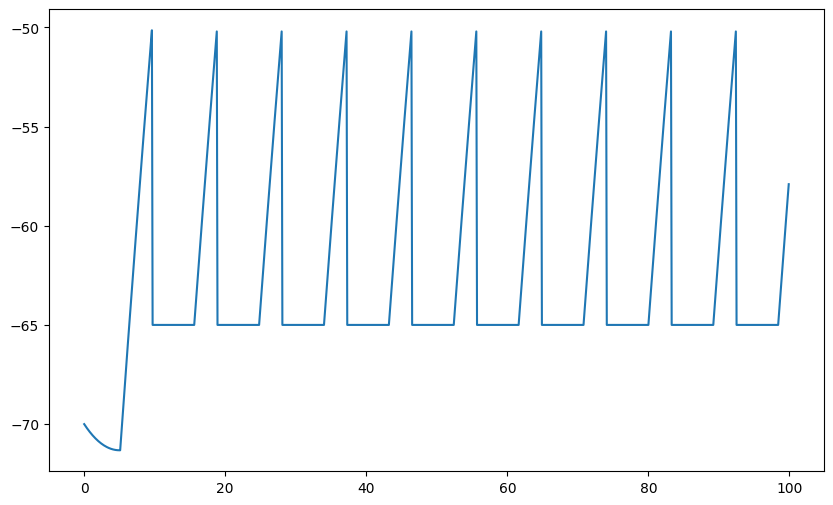

In [9]:
from brian2 import *
%matplotlib inline

start_scope()

# Global Parameters
simulation_time = 100 * ms
V_REST = -70 * mV
V_RESET = -65 * mV
FIRING_THRESHOLD = -50 * mV
MEMBRANE_RESISTANCE = 10. * Mohm
ABSOLUTE_REFRACTORY_PERIOD = 6.0 * ms
MEMBRANE_TIME_SCALE = 20.0 * ms



G_L = 10 * nsiemens      
E_L = -65 * mV           

G_NA = 35 * nsiemens     
E_NA = 55 * mV           

G_K = 9 * nsiemens       
E_K = -90 * mV          

eqs_L = """
dv/dt = ((-(v - E_L) * G_L) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE  + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE : volt (unless refractory)
"""


eqs_Na = """
dv/dt = ((-(v - E_NA) * G_NA) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE : volt (unless refractory)
"""

eqs_K = """
dv/dt = ((-(v - E_K) * G_K) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current(t , i) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE: volt (unless refractory)
"""

#Na, K, and L channels

neuronNa = NeuronGroup(1, model=eqs_Na, reset='v = 50 * mV', threshold='v > 65 * mV',
                       refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronNa.v = V_REST

neuronK = NeuronGroup(1, model=eqs_K, reset='v = -85 * mV', threshold='v > -70 * mV',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronK.v = V_REST

neuronL = NeuronGroup(1, model=eqs_L, reset='v = -65 * mV', threshold='v > -50 * mV',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuronL.v = V_REST


state_monitorNa = StateMonitor(neuronNa, ["v"], record=True)
state_monitorK = StateMonitor(neuronK, ["v"], record=True)
state_monitorL = StateMonitor(neuronL, ["v"], record=True)


run(simulation_time)

start_scope()

input_current_neuron1 = ((state_monitorL.v[0] - V_REST) + (state_monitorK.v[0] - V_REST) + 
                         (state_monitorNa.v[0] - V_REST)) / MEMBRANE_RESISTANCE


input_current_neuron1 = TimedArray(input_current_neuron1, dt=defaultclock.dt)


eqs_neuron1 = """
dv/dt = ((-(v - E_K) * gs) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE + (input_current_neuron1(t) / MEMBRANE_TIME_SCALE) * MEMBRANE_RESISTANCE: volt (unless refractory)
"""

neuron1 = NeuronGroup(1, model=eqs_neuron1, reset='v = V_RESET', threshold='v > FIRING_THRESHOLD',
                      refractory=ABSOLUTE_REFRACTORY_PERIOD, method='exponential_euler')
neuron1.v = V_REST

# StateMonitor for neuron 1
state_monitor1 = StateMonitor(neuron1, ["v"], record=True)
spikemon1 = SpikeMonitor(neuron1)

run(simulation_time)


figure(figsize=(10, 6))
# plot(state_monitorNa.t/ms, state_monitorNa.v[0]/mV, label='Sodium Channel (Na)')
# plot(state_monitorK.t/ms, state_monitorK.v[0]/mV, label='Potassium Channel (K)')
# plot(state_monitorL.t/ms, state_monitorL.v[0]/mV, label='Leak Channel (L)')
plot(state_monitor1.t/ms, state_monitor1.v[0]/mV, label='Neuron 1')
plot(state_monitor1.t/ms, input_current)
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()
show()

 # HODGKIN HUXLEY - ZIGZAG WAVE

WARNING    't' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 100. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


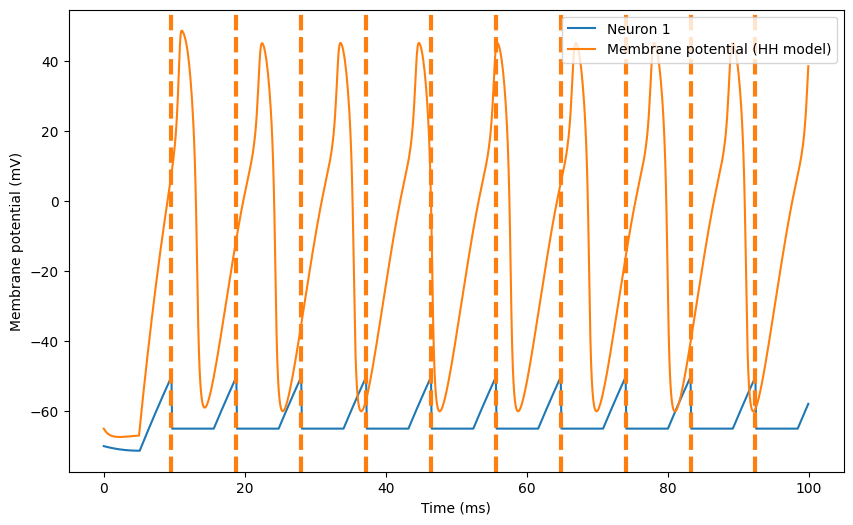

In [ ]:

start_scope()


simulation_time = 100 * ms

El = -65 * mV             # Resting potential for Leak channel
EK = -77 * mV             # Resting potential for Potassium channel
ENa = 50 * mV             # Resting potential for Sodium channel
gl = 0.1 * msiemens       # Adjusted conductance for Leak channel
gK = 30 * msiemens        # Adjusted conductance for Potassium channel
gNa = 120 * msiemens      # Adjusted conductance for Sodium channel
C = 1 * ufarad            # Membrane capacitance

gs = G_L + G_NA + G_K

# Hodgkin-Huxley model equations 
eqs = """
I_e = input_current(t,i) : amp
membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
    gl*(El-vm) + gK*n**4*(EK-vm) : amp
alphah = .07*exp(-.05*vm/mV)/ms    : Hz
alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
betam = 4*exp(-.0556*vm/mV)/ms : Hz
betan = .125*exp(-.0125*vm/mV)/ms : Hz
dh/dt = alphah*(1-h)-betah*h : 1
dm/dt = alpham*(1-m)-betam*m : 1
dn/dt = alphan*(1-n)-betan*n : 1
dvm/dt = membrane_Im/C : volt
"""

neuron = NeuronGroup(1, eqs, method="exponential_euler")

neuron.vm = El
neuron.m = 0.05
neuron.h = 0.6
neuron.n = 0.32

state_monitor = StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

run(simulation_time)


figure(figsize=(10, 6))
plot(state_monitor1.t/ms, state_monitor1.v[0]/mV, label='Neuron 1')
for t in spikemon1.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
plot(state_monitor.t/ms, state_monitor.vm[0]/mV, label="Membrane potential (HH model)")
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
legend()
show()
